In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

from functools import reduce

import anndata as ad
import scanorama
import seaborn as sns
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import multiprocessing

n_cpu = multiprocessing.cpu_count()

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [4]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


In [5]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
    "SP Donor A"
]


In [6]:
adata_path = data_dir / "metadata" / f"combined_10_07.h5ad"
adata = sc.read_h5ad(adata_path)

# Cell neighborhood

## Create Neighbor graph

In [7]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree

def get_NN(adata, n):
    data = adata.obsm["spatial"]
    fit = NearestNeighbors(n_neighbors=n+1).fit(data)
    m = fit.kneighbors(data)
    # m = m[0], m[1] # Distances, Indices
    m = m[0][:, 1:], m[1][:, 1:]
    
    # sort_neighbors
    args = m[0].argsort(axis=1)
    add = (
        np.arange(m[1].shape[0]) * m[1].shape[1]
    )  # arange for number of elements with step of number of neighbors
    sorted_indices = m[1].flatten()[
        args + add[:, None]
    ]  # Extract indices in sorted order
    return sorted_indices

def get_NN_radius(adata, r):
    data = adata.obsm["spatial"]
    fit = NearestNeighbors(radius=r).fit(data)
    m = fit.radius_neighbors(data, return_distance=False)
    
    # Put in dataframe format
    neighbours = pd.DataFrame(m.tolist(), index = adata.obs.index)
    return neighbours

def neighbor_frequency(adata, n=10, radius=25, var='clusters', radius_type='radius'):
    dummies = pd.get_dummies(adata.obs[var])
    values = dummies.values
    
    if radius_type == 'radius':
        phenomap = dict(zip(list(range(len(adata))), adata.obs[var].tolist()))
        neighbours=get_NN_radius(adata, radius)
        for i in neighbours.columns:
            neighbours[i] = neighbours[i].dropna().map(phenomap, na_action='ignore')
        neighbours = neighbours.dropna(how='all')
        window = neighbours.stack().str.get_dummies().sum(level=0)
        window = window.div(window.sum(axis=1), axis=0)
    else:
        cols = get_NN(adata, n)
        window = values[cols].flatten()
        window = window.reshape(-1, n, dummies.shape[1])
        window = window.sum(axis=1) / n
        window = pd.DataFrame(window, columns=dummies.columns.tolist())
    assert len(window) == len(adata.X)
    return window

In [8]:
n_neighbors = 20
r = 25
windows = []
var='merged'
# var = 'clusters'

# Loop to get window size 
for d in donors:
    print(d)
    adata_subset = adata[adata.obs.Dataset == d, :]
    
    # sq.gr.spatial_neighbors(adata_subset, n_neighs=n_neighbors)
    window = neighbor_frequency(adata_subset, n=n_neighbors, var=var, radius=r,)
    assert len(window) == len(adata_subset.X)

    windows.append(window)

LN Donor A
LN Donor E
INT Donor B
INT Donor E
TS Donor A
TS Donor E
SP Donor A


In [9]:
window = pd.concat(windows)
window = window.fillna(0)
window.shape

(1955450, 15)

In [10]:
window.isna().values.any()

False

In [11]:
adata

AnnData object with n_obs × n_vars = 1955450 × 23
    obs: 'ROI', 'Cell', 'Dataset', 'leiden', 'merged'
    uns: 'Dataset_colors', 'dendrogram_leiden', 'dendrogram_merged', 'leiden', 'merged_colors', 'neighbors'
    obsm: 'X_scanorama', 'X_tsne', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

## CN clustering

In [12]:
from sklearn.cluster import MiniBatchKMeans
from kneed import KneeLocator
from matplotlib.ticker import MaxNLocator

In [13]:
adata_CN = ad.AnnData(window)
adata_CN.raw = adata.copy()
adata_CN.obs = adata.obs.copy()
adata_CN.uns = adata.uns.copy()
adata_CN.obsm = adata.obsm.copy()
adata_CN.obsp = adata.obsp.copy() 
adata_CN.var_names = window.columns.tolist()

In [14]:
sc.tl.pca(adata_CN, n_comps=12)

computing PCA
    with n_comps=12
    finished (0:00:00)


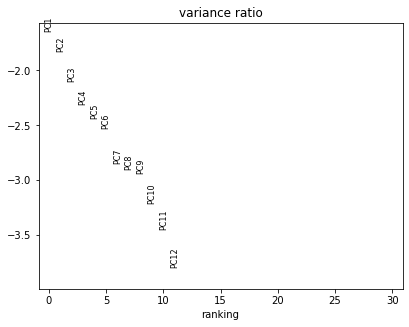

In [15]:
sc.pl.pca_variance_ratio(adata_CN, log=True)


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 12288 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 12288 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 12288 or by setting the environment variable OMP_NUM_THRE

The suggested number of clusters =  14


C:\Users\thu71\AppData\Local\Temp\ipykernel_118300\1794930563.py:30: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title("The suggested number of clusters = " + np.str(kneedle_point.knee))


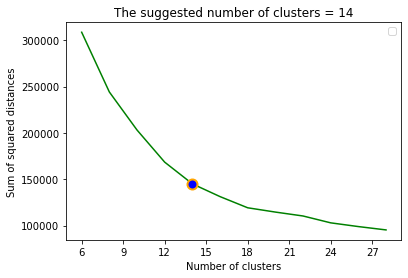

In [17]:
proj_3d = adata_CN.X

n_components = np.arange(6,30, step=2)
models = [
    MiniBatchKMeans(random_state=5, n_clusters=n).fit(proj_3d) for n in n_components
]

BIC_Scores = [m.inertia_ for m in models]
kneedle_point = KneeLocator(
    n_components, BIC_Scores, curve="convex", direction="decreasing"
)
print("The suggested number of clusters = ", kneedle_point.knee)
Elbow_idx = np.where(BIC_Scores == kneedle_point.knee_y)[0]

plt.plot(
    n_components,
    BIC_Scores,
    "-g",
    marker="o",
    markerfacecolor="blue",
    markeredgecolor="orange",
    markeredgewidth="2",
    markersize=10,
    markevery=Elbow_idx,
)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc="best")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
plt.title("The suggested number of clusters = " + np.str(kneedle_point.knee))
plt.show()

In [18]:
n_neighborhoods = 14

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=0)

labels = km.fit_predict(adata_CN.X)
k_centroids = km.cluster_centers_

C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 12288 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


## Merge clusters based on dendrogram

In [19]:
import matplotlib

In [21]:
df_cluster = pd.DataFrame()
df_cluster["Clusters"] = labels
df_cluster["Clusters"] = df_cluster["Clusters"].astype(str).astype('category')
df_cluster["Leiden"] = adata.obs[var].tolist()
df_cluster_count = df_cluster.value_counts().to_frame('counts').reset_index()

df_cluster_count['Density'] = df_cluster_count.groupby('Clusters')["counts"].apply(lambda x: x / x.sum())

clusters = df_cluster["Clusters"].unique().tolist()
clusters.sort(key=int)

In [22]:
cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()
colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v/255 for k,v in zip(labels, colors_rgb)}

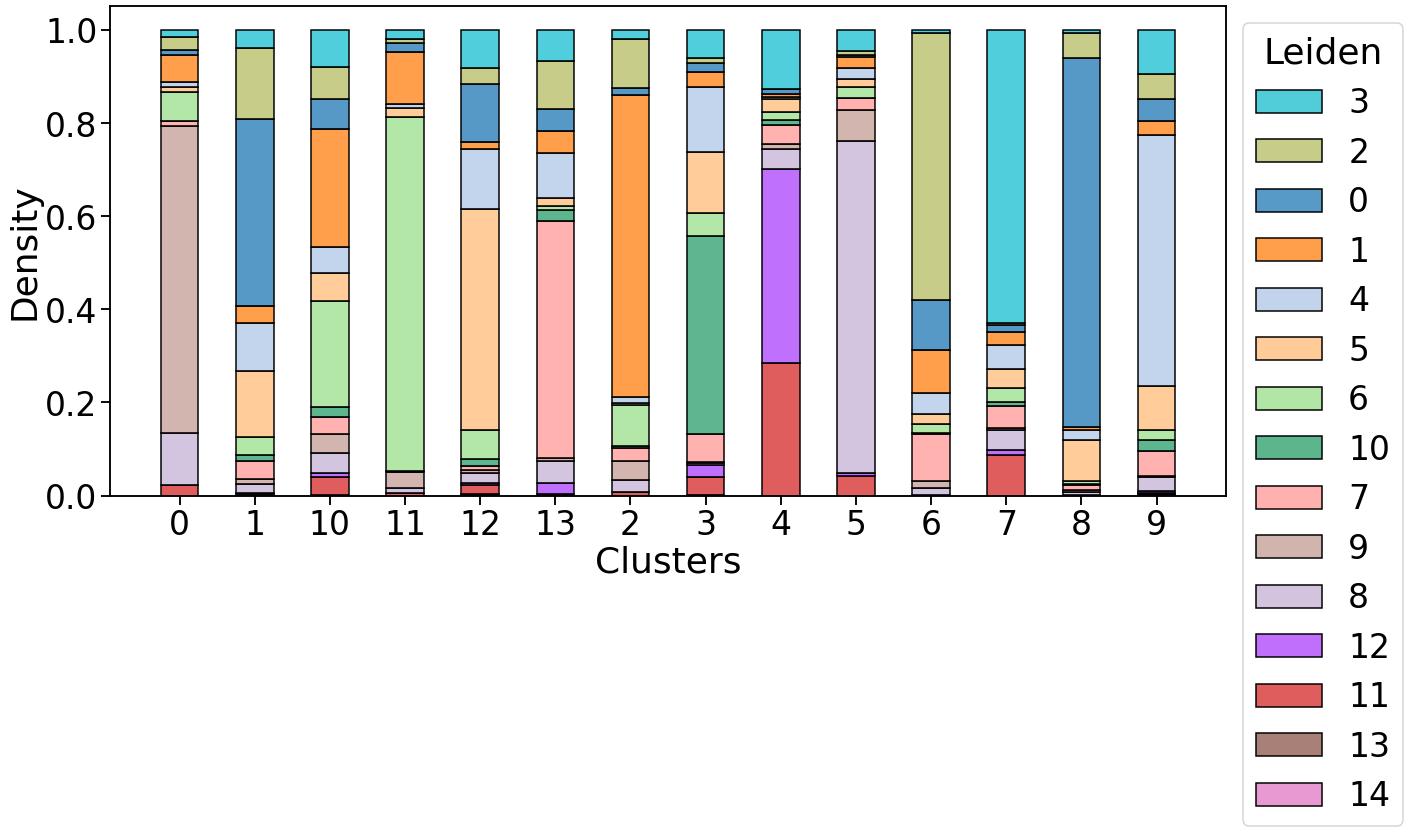

In [23]:
with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(20, 9))
    ax = sns.histplot(data=df_cluster_count, x='Clusters' , hue='Leiden', weights='Density', discrete=True, multiple='stack', shrink=0.5, palette=colors_rgb_dict, edgecolor='k',)
    ax.set_ylabel('Density')

    # Fix the legend so it's not on top of the bars.
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1, 1))


In [51]:
# Plot count
df_count = (
 df_cluster_count.loc[:,['Clusters', 'Leiden', 'Density']]
 .pivot(index='Clusters', columns='Leiden')
 .fillna(0)
 .droplevel(0, axis=1)
)

adata_count = sc.AnnData(df_count.values)
adata_count.var_names = df_count.columns.tolist()
adata_count.obs['Clusters'] = df_count.index.tolist()
adata_count.obs['Clusters'] = adata_count.obs['Clusters'].astype('category')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Clusters']`


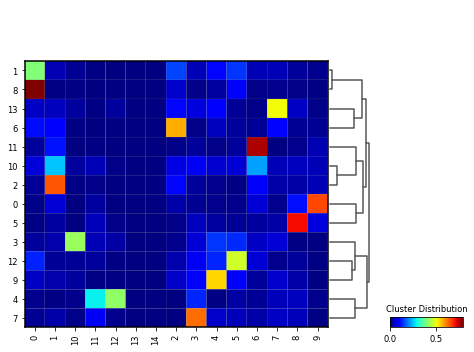

In [52]:
sc.pl.matrixplot(
    adata_count,
    adata_count.var_names.tolist(),
    "Clusters",
    dendrogram=True,
    colorbar_title="Cluster Distribution",
    cmap="jet",
    use_raw=False,
    standard_scale='obs'
)

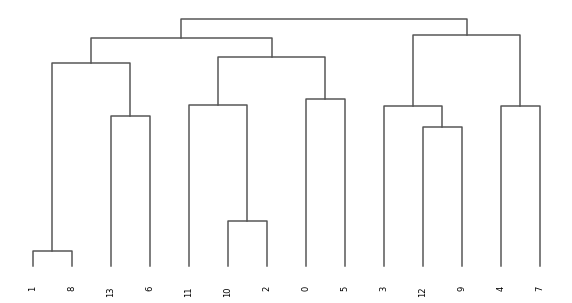

In [53]:
# Plot stand alone dendrogram
from scanpy.plotting._anndata import _plot_dendrogram

fig, dendro_ax = plt.subplots(1, 1, figsize=(10,5))
_plot_dendrogram(dendro_ax, adata_count, groupby="Clusters", orientation='top', remove_labels=False)

In [54]:
type_dict = {'8':'1',
             '10':'2'
            }

In [55]:
adata_count.obs['CN'] = (
    adata_count.obs['Clusters']
    .map(lambda x: type_dict.get(x, x))
    .astype("category")
)


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_CN']`


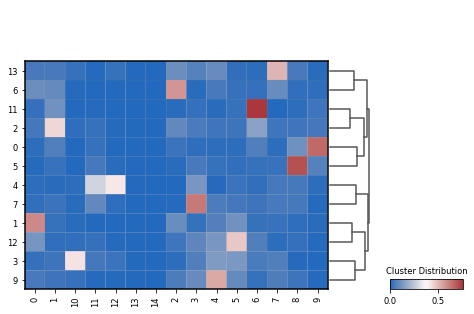

In [56]:
sc.tl.dendrogram(adata_count, 'CN')
sc.pl.matrixplot(
    adata_count,
    adata_count.var_names.tolist(),
    "CN",
    dendrogram=True,
    colorbar_title="Cluster Distribution",
    cmap="vlag",
    use_raw=False,
    standard_scale='obs'
)

# Add clustering labels to adata

In [57]:
labels = np.array(km.fit_predict(adata_CN.X)).astype(str)

C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 12288 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [58]:
adata_CN.obs["LDA_Kmeans"] = labels
adata_CN.obs['CN'] = (
    adata_CN.obs["LDA_Kmeans"]
    .map(lambda x: type_dict.get(x, x))
    .astype("category")
)

adata_CN.obs["CN"] = adata_CN.obs["CN"].astype("category")
adata_CN.uns["CN_colors"] = sc.pl.palettes.vega_20[:len(np.unique(adata_CN.obs['CN']))]

# Reorder cat
clusters = np.unique(adata_CN.obs["CN"]).tolist()
clusters.sort(key=int)
adata_CN.obs["CN"] = adata_CN.obs["CN"].cat.reorder_categories(clusters)

In [75]:
ori_var = 'merged'
df_cluster = pd.DataFrame()
df_cluster["Clusters"] = adata_CN.obs['CN']
df_cluster["Clusters"] = df_cluster["Clusters"].astype(str).astype('category')
df_cluster["Leiden"] = adata.obs[ori_var].tolist()
df_cluster_count = df_cluster.value_counts().to_frame('counts').reset_index()

df_cluster_count['Density'] = df_cluster_count.groupby('Clusters')["counts"].apply(lambda x: x / x.sum())

clusters = df_cluster["Clusters"].unique().tolist()
clusters.sort(key=int)

In [76]:

cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()
colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v/255 for k,v in zip(labels, colors_rgb)}

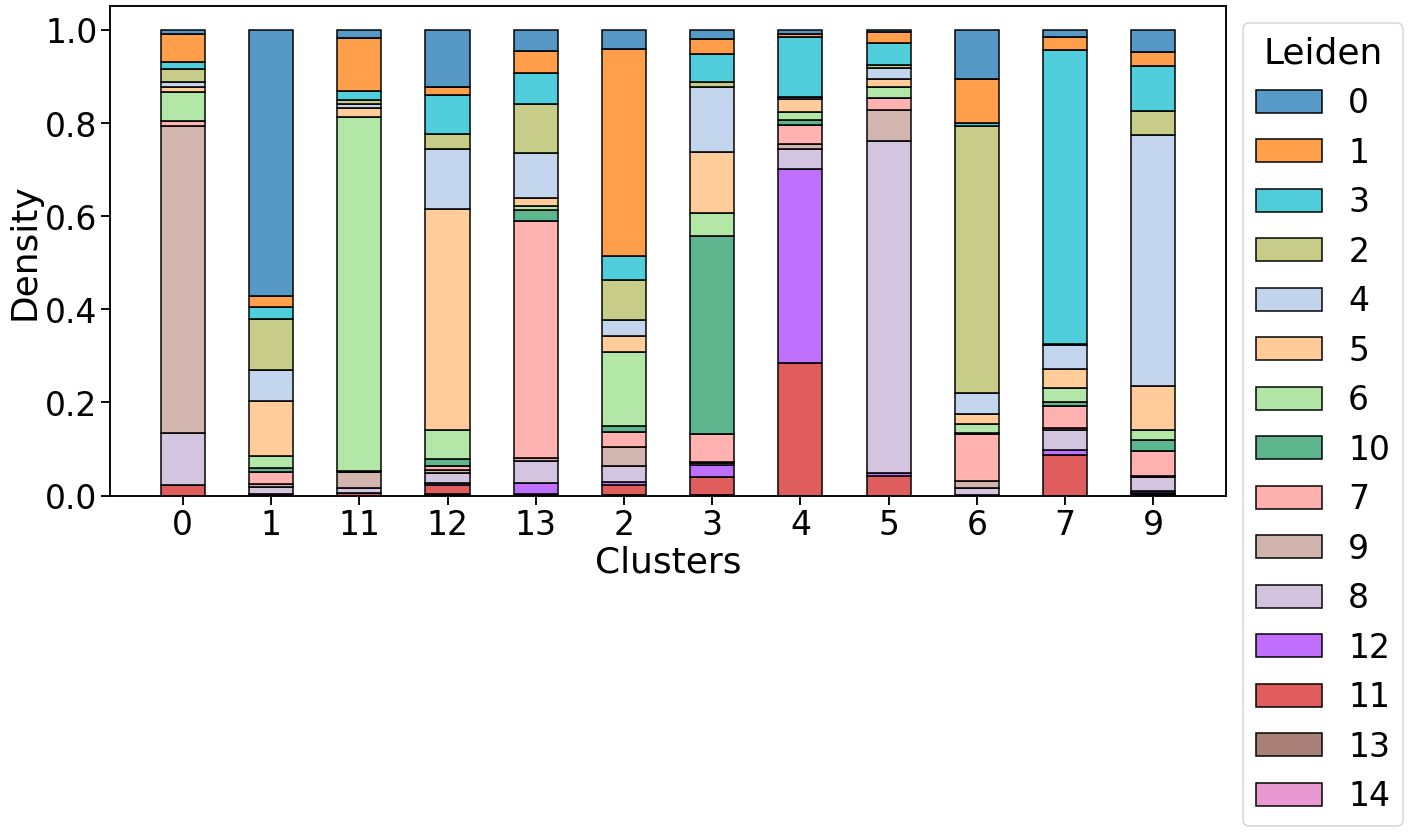

In [77]:
with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(20, 9))
    ax = sns.histplot(data=df_cluster_count, x='Clusters' , hue='Leiden', weights='Density', discrete=True, multiple='stack', shrink=0.5, palette=colors_rgb_dict, edgecolor='k',)
    ax.set_ylabel('Density')

    # Fix the legend so it's not on top of the bars.
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1, 1))


In [78]:
donors = adata_CN.obs.Dataset.unique()
dfs = []

for donor in donors:
    adata_subset = adata_CN[adata_CN.obs.Dataset == donor,:]
    
    # Summary of the phenotyping
    
    df = pd.DataFrame(adata_subset.obs['CN'].value_counts())
    df.columns=[donor]
    dfs.append(df)
    
df = pd.concat(dfs, axis=1)

In [79]:
df.to_clipboard()

In [80]:
df

,LN Donor A,LN Donor E,INT Donor B,INT Donor E,TS Donor A,TS Donor E,SP Donor A
2,53520,93625,18318,13924,37998,53434,73371
1,43472,62022,18212,9981,72985,84031,25948
12,24439,84252,9238,17167,6550,11562,13771
9,23534,8134,21208,21060,19313,49312,21729
7,17609,6348,14383,70987,40164,32170,237
6,17591,12362,56544,65732,26172,20821,511
13,9408,4109,15353,47226,25949,2787,12834
11,2725,1266,219,129,38425,53085,1464
5,279,6590,2697,13344,31494,17385,822
4,248,50,35024,10716,1213,8069,5303


# Plot cell mask

In [81]:
import matplotlib 
from PIL import Image

def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img


def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


In [82]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

In [83]:
masks = {}
for d in donors:
    masks[d] = get_masks(data_dir / "masks" / d)

In [84]:
import matplotlib 

var = 'CN'

cluster_label_order = adata_count.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata_CN.uns[f"{var}_colors"]
labels = adata_CN.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}


In [85]:
len(cluster_label_order)

12

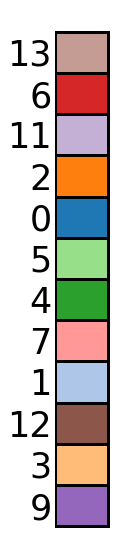

In [86]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,10))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [ ]:
for d in adata.obs.Dataset.unique():
    adata_donor = adata_CN[adata_CN.obs.Dataset == d, :]
    with rc_context({"figure.figsize": (20, 20)}):
        sc.pl.spatial(adata_donor, color='CN', spot_size=10)
    
    plt.show()
    break

In [87]:
size = 1000

for d in adata.obs.Dataset.unique():
    adata_donor = adata_CN[adata_CN.obs.Dataset == d, :]

    # Create combined images
    y_max, x_max = get_img_size(arrangement[d])
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[d].keys():
            continue

        # Get dataset
        adata_subset = adata_donor[adata_donor.obs.ROI == i, :]

        # Get mask
        mask = masks[d][str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for ii,l in enumerate(labels):
            cell_id = adata_subset[adata_subset.obs.CN== l].obs.Cell.to_list()
            label2cell[ii] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[d][i][0] - 1)
        x = max(0, arrangement[d][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img

    save_path = p_dir / "figures" / "clustering" / f"CN_small_Cluster_subset{d}.png"
    img_combined = Image.fromarray(img_combined)
    img_combined.save(save_path)
